# What you should remember about dropout:

1. Dropout is a regularization technique.
2. You only use dropout during training. Don't use dropout (randomly eliminate nodes) during test time.
3. Apply dropout both during forward and backward propagation.
4. During training time, divide each dropout layer by keep_prob to keep the same expected value for the activations. For example, if keep_prob is 0.5, then we will on average shut down half the nodes, so the output will be scaled by 0.5 since only the remaining half are contributing to the solution. Dividing by 0.5 is equivalent to multiplying by 2. Hence, the output now has the same expected value. You can check that this works even when keep_prob is other values than 0.5.

## Let's get started !

## Packages

Let's first import all the packages that you will need during this assignment. 
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](http://www.pythonware.com/products/pil/) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.
- dnn_app_utils provides the functions implemented in the "Building your Deep Neural Network: Step by Step" assignment to this notebook.
- np.random.seed(1) is used to keep all the random function calls consistent. It will help us grade your work.

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## Dataset

**Problem Statement**: You are given a dataset (".csv") containing:

Let's get more familiar with the dataset. Load the data by running the cell below.

In [2]:
# Loading the data 
def read_data(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    num_points = len(lines)
    dim_points = 28 * 28
    data = np.empty((num_points, dim_points))
    labels = np.empty(num_points)
    
    for ind, line in enumerate(lines):
        num = line.split(',')
        labels[ind] = int(num[0])
        data[ind] = [ int(x) for x in num[1:] ]
        
    return (data, labels)

train_set_x_flatten, train_y = read_data("sample_train.csv")
test_set_x_flatten, test_y = read_data("sample_test.csv")
print(train_set_x_flatten.shape, test_set_x_flatten.shape)
print(train_y.shape, test_y.shape)

(6000, 784) (1000, 784)
(6000,) (1000,)


The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 2.0


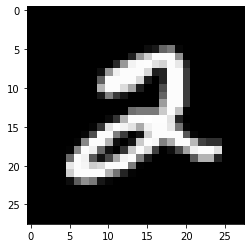

In [3]:
# Example of a picture
index = 5
img = train_set_x_flatten[index,:].reshape(28,28)
plt.imshow(img, cmap = 'gray')
print ("y = " + str(train_y[index]) )
#print(type(train_y[index]))

In [4]:
# Reshape the training and test examples 

train_set_x_flatten = train_set_x_flatten.T
#train_set_y = train_set_y.reshape(-1,1)
target = np.array(train_y).reshape(-1)
t = [int(x) for x in target]
print((t[5]))
train_set_y = np.eye(10)[t].T

print(train_set_y[:,5])

test_set_x_flatten = test_set_x_flatten.T
target = np.array(test_y).reshape(-1)
t = [int(x) for x in target]
print((t[2]))
test_set_y = np.eye(10)[t].T
print(test_set_y[:,2])

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

# Standardize data to have feature values between 0 and 1.
train_x = train_set_x_flatten/255.
test_x = test_set_x_flatten/255.


2
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
1
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
train_set_x_flatten shape: (784, 6000)
train_set_y shape: (10, 6000)
test_set_x_flatten shape: (784, 1000)
test_set_y shape: (10, 1000)


# Dropout

Dropout is a widely used regularization technique that is specific to deep learning. It randomly shuts down some neurons in each iteration.
Overfitting has always been the enemy of generalization. Dropout is very simple and yet very effective way to regularize networks by reducing coadaptation between the neurons.

The general methodology to build a Neural Network is to:

1. Define the neural network structure ( # of input units, # of hidden units, etc).
2. Initialize the model's parameters
3. Loop:
     - Implement forward propagation
     - Compute loss
     - Implement backward propagation to get the gradients
     - Update parameters (gradient descent)

## Forward_propagation with dropout

In [5]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [6]:
# Sigmoid Activation

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    
    s = 1.0/(1.0 + np.exp(-1.0 * z))
    
    return s

In [7]:
#forward_propagation
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
            W1 -- weight matrix of shape (n_h, n_x)
            b1 -- bias vector of shape (n_h, 1)
            W2 -- weight matrix of shape (n_y, n_h)
            b2 -- bias vector of shape (n_y, 1)
    keep_prob -- probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    Z1 = np.add(np.matmul(W1, X), b1)
    A1 = np.tanh(Z1)
    ## Dropout
    D1 = np.random.rand(A1.shape[0], A1.shape[1])   # Step 1: initialize matrix D1 = np.random.rand(..., ...)
    D1 = D1 < keep_prob                             # Step 2: convert entries of D1 to 0 or 1 (using keep_prob as the threshold)
    A1 = np.multiply(A1, D1)                        # Step 3: shut down some neurons of A1
    A1 = A1/keep_prob                               # Step 4: scale the value of neurons that haven't been shut down

    Z2 = np.add(np.matmul(W2, A1), b2)
    A2 = sigmoid(Z2)
    
    assert(A2.shape == (W2.shape[0], X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "D1": D1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [8]:
# compute_cost

def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (n_x, number of examples)
    Y -- "true" labels vector of shape (n_y, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    logprobs = np.multiply(Y, np.log(A2)) + np.multiply((1 - Y), np.log(1 - A2))
    cost = (-1.0/(m*Y.shape[0])) * np.sum(logprobs)
    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 

    assert(isinstance(cost, float))
    
    return cost

In [9]:
# backward_propagation

def backward_propagation_with_dropout(parameters, cache, X, Y, keep_prob):
    """
    Implement the backward propagation with Dropout
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (n_x, number of examples)
    Y -- "true" labels vector of shape (n_y, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters["W1"]
    W2 = parameters["W2"]
        
    # Retrieve also A1, A2 and D1 from dictionary "cache".
    A1 = cache["A1"]
    A2 = cache["A2"]
    D1 = cache["D1"]
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ2 = A2 - Y
    dW2 = (1.0/m) * np.matmul(dZ2, np.transpose(A1))
    db2 = (1.0/m) * np.sum(dZ2, axis=1, keepdims=True)
    dA1 = np.dot(W2.T, dZ2)
    ## Dropout
    dA1 = np.multiply(D1, dA1)      # Step 1: Apply mask D2 to shut down the same neurons as during the forward propagation
    dA1 = dA1/keep_prob             # Step 2: Scale the value of neurons that haven't been shut down
    
    dZ1 = np.multiply(dA1, (1 - np.power(A1, 2)))
    dW1 = (1.0/m) * np.matmul(dZ1, np.transpose(X))
    db1 = (1.0/m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

## Implement the update rule.

Use gradient descent. We need (dW1, db1, dW2, db2) in order to update (W1, b1, W2, b2).

General gradient descent rule:  θ=θ−α∂J∂θ  where  α  is the learning rate and  θ  represents a parameter.

In [10]:
# update_parameters

def update_parameters(parameters, grads, learning_rate = 0.0075):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Retrieve each gradient from the dictionary "grads"
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    # Update rule for each parameter
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [11]:
# nn_model

def nn_model(X, Y, n_h, num_iterations = 10000, learning_rate=0.05, keep_prob=0.5, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (n_x, number of examples)
    Y -- labels of shape (n_y, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    n_x = X.shape[0]
    n_y = Y.shape[0]
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)
    costs = []
    for i in range(0, num_iterations):
         
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation_with_dropout(X, parameters, keep_prob = keep_prob)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y, parameters)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation_with_dropout(parameters, cache, X, Y, keep_prob)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads, learning_rate=learning_rate)
        
        # cache all about model
        trained_model = {
            "layer_sizes": (n_x, n_h, n_y),
            "learning_rate": learning_rate,
            "costs": costs,
            "parameters": parameters
        }

        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return trained_model

In [12]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 784     # num_px * num_px * 3
n_h = 180
n_y = 10
layers_dims = (n_x, n_h, n_y)

Cost after iteration 0: 0.692426
Cost after iteration 100: 0.288587
Cost after iteration 200: 0.198385
Cost after iteration 300: 0.155000
Cost after iteration 400: 0.129795
Cost after iteration 500: 0.115082
Cost after iteration 600: 0.105246
Cost after iteration 700: 0.097728
Cost after iteration 800: 0.093920
Cost after iteration 900: 0.092018


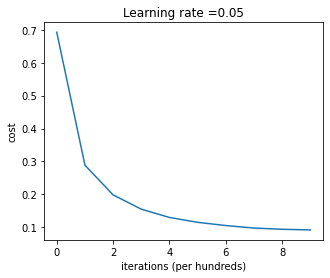

In [13]:
trained_model = nn_model(train_x, train_set_y, n_h, num_iterations = 1000, print_cost=True)

In [14]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((y.shape[0],m))
    
    # Forward propagation    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = np.add(np.matmul(W1, X), b1)
    A1 = np.tanh(Z1)
    Z2 = np.add(np.matmul(W2, A1), b2)
    A2 = sigmoid(Z2)

    for i in range(0, A2.shape[1]):
        temp = np.array(A2[:,i])
        t = np.where(temp == np.amax(temp))
        p[t[0],i] = 1

    print("Accuracy: "  + str(np.sum(p == y)/(m* y.shape[0])))
        
    return p

In [15]:
predictions_train = predict(train_x, train_set_y, trained_model['parameters'])

Accuracy: 0.9819333333333333


In [16]:
predictions_test = predict(test_x, test_set_y, trained_model['parameters'])

Accuracy: 0.9742


## Visualization of MLP weights on MNIST

This example shows how to plot some of the first layer weights in a MLPClassifier trained on the MNIST dataset.

The input data consists of 28x28 pixel handwritten digits, leading to 784 features in the dataset. Therefore the first layer weight matrix have the shape (784, hidden_layer_sizes[0]). We can therefore visualize a single column of the weight matrix as a 28x28 pixel image.

For better understanding, visit https://ml4a.github.io/ml4a/looking_inside_neural_nets/

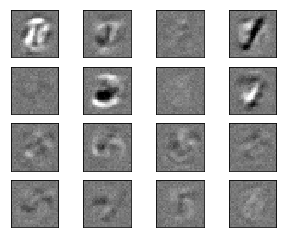

In [17]:
#print((np.array(list(trained_model['parameters']['W1'])).T).shape)

fig, axes = plt.subplots(4,4)
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = (np.array(list(trained_model['parameters']['W1'])).T).min(), (np.array(list(trained_model['parameters']['W1'])).T).max()
for coef, ax in zip((np.array(list(trained_model['parameters']['W1']))), axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

## Play with different values of dropout-probabilities

Cost after iteration 0: 0.693949
Cost after iteration 100: 0.266358
Cost after iteration 200: 0.168349
Cost after iteration 300: 0.124797
Cost after iteration 400: 0.102499
Cost after iteration 500: 0.088817
Cost after iteration 600: 0.079496
Cost after iteration 700: 0.072904
Cost after iteration 800: 0.068021
Cost after iteration 900: 0.064214
Cost after iteration 1000: 0.061110


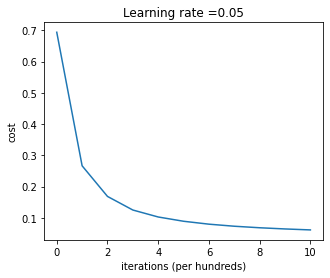

Cost after iteration 0: 0.694097
Cost after iteration 100: 0.277478
Cost after iteration 200: 0.179667
Cost after iteration 300: 0.135377
Cost after iteration 400: 0.112405
Cost after iteration 500: 0.098429
Cost after iteration 600: 0.088486
Cost after iteration 700: 0.081264
Cost after iteration 800: 0.076190
Cost after iteration 900: 0.071796
Cost after iteration 1000: 0.068444


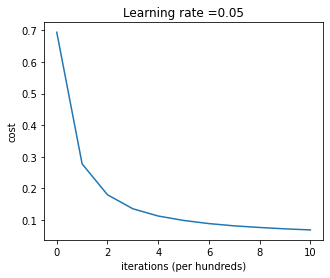

Cost after iteration 0: 0.692788
Cost after iteration 100: 0.291701
Cost after iteration 200: 0.204303
Cost after iteration 300: 0.159416
Cost after iteration 400: 0.133068
Cost after iteration 500: 0.117016
Cost after iteration 600: 0.106503
Cost after iteration 700: 0.101083
Cost after iteration 800: 0.095393
Cost after iteration 900: 0.093822
Cost after iteration 1000: 0.093434


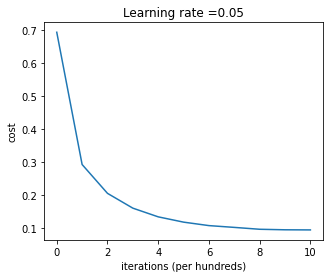

Cost after iteration 0: 0.693659
Cost after iteration 100: 0.313423
Cost after iteration 200: 0.258564
Cost after iteration 300: 0.215126
Cost after iteration 400: 0.195171
Cost after iteration 500: 0.196833
Cost after iteration 600: 0.215708
Cost after iteration 700: 0.206015
Cost after iteration 800: 0.260700
Cost after iteration 900: 0.242260
Cost after iteration 1000: 0.244544


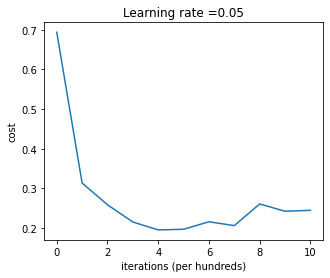

In [18]:
keep_probs = [1.0, 0.7, 0.5, 0.3]
num_iterations=1001
learning_rate=0.05
trained_models = []

for prob in keep_probs:
    trained_model = nn_model(train_x, train_set_y, n_h,
                             num_iterations = num_iterations, learning_rate=learning_rate,
                             keep_prob=prob, print_cost=True
                            )

## References:
https://datascience-enthusiast.com/DL/Improving_DeepNeural_Networks_Regularization.html